In [36]:
import pandas as pd
import numpy as np
from pathlib import Path

from src.models.buffered_cv import BufferedBlockedSplit
import src.features.build_features as feat

idx = pd.IndexSlice

In [37]:
data_path = Path('../data/processed/cup_10_min_aggs.parquet')
assert data_path.exists()

In [38]:
met = pd.read_parquet(data_path)
met.head(1).T

Air_Temp_87m                                             \
                           count        max       mean        min       var   
timestamp                                                                     
2018-12-31 17:00:00          600 -15.477113 -15.691004 -15.805410  0.002746   
2018-12-31 17:10:00          600 -15.577877 -15.798286 -15.977685  0.004473   
2018-12-31 17:20:00          600 -15.714396 -16.011219 -16.208467  0.008372   

                    Cup_WS_C1_105m                                         \
                           3s_gust count integrated_low_freq_ke       max   
timestamp                                                                   
2018-12-31 17:00:00       8.805074   600               0.212934  8.917205   
2018-12-31 17:10:00       8.546263   600               0.368811  8.775206   
2018-12-31 17:20:00       8.774642   600               0.196161  8.879639   

                               ... Vane_WD_122m                        \
                         mean  ...        count        max       mean   
timestamp                      ...                                      
2018-12-31 17:00:00  7.490526  ...          600  33.494221  22.310926   
2018-12-31 17:10:00  7.050964  ...          600  31.750303  18.813911   
2018-12-31 17:20:00  7.794179  ...          600  33.310650  18.989834   

                                          Vane_WD_87m                        \
                           min        var       count        max       mean   
timestamp                                                                     
2018-12-31 17:00:00  11.305159  15.657919         600  36.993736  23.034079   
2018-12-31 17:10:00   3.709938  23.281769         600  34.089355  21.583694   
2018-12-31 17:20:00   5.362070  25.907095         600  35.241886  20.046831   

                                           
                           min        var  
timestamp                                  
2018-12-31 17:00:00  10.439404  17.228054  
2018-12-31 17:10:00   3.040152  25.558174  
2018-12-31 17:20:00   2.509987  19.110186  

[3 rows x 34 columns]

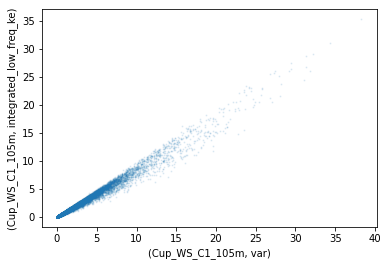

In [57]:
met.plot.scatter(('Cup_WS_C1_105m', 'var'), ('Cup_WS_C1_105m', 'integrated_low_freq_ke'), alpha=0.1, s=1)

From the plot above, linear regression is an obvious choice of baseline model. But first I'll do some feature engineering.
# Feature engineering
## Cyclic features
There are three cyclic features here: wind direction angle, seasonal cycle, and diurnal cycle. In each case, points at the beginning and end of the data ranges are actually adjacent. These relationships can't be captured by a single dimension, so I'll convert them to 2 component dimensions with sine and cosine transforms.
### Wind Direction (angular)
Like temperature, there are two wind direction measurements at different heights. Again, I'll express them in terms of a reference and difference, and cast the difference in terms of a gradient wrt to height. This is NOT a linear transform due to the cyclic wrapping. I'll leave the difference as a single dimension with range (-180, 180], simply because there will rarely be differences more than 90 degrees.

## Domain Specific
To express information about wind speed vs height, I'll compute the wind shear exponent. 

I'll express the temperature difference in in terms of a gradient wrt height for greater portability between differently-instrumented towers. This is just a linear transform so shouldn't change any models.

In a full application, I would add more domain specific features like bulk richardson number and monin-obukhov length. But the combination of wind shear, temperature gradient, and veer provide similar information.


In [45]:
met.loc[:, ('metrics', 'shear_exp')] = feat.power_law_shear(met.loc[:,('Cup_WS_C1_130m', 'mean')],
                                                        met.loc[:,('Cup_WS_C1_105m', 'mean')],
                                                        130,
                                                        105)

In [46]:
met.loc[:, idx['DeltaT_122_87m', 'max':]] = met.loc[:, idx['DeltaT_122_87m', 'max':]] / (122 - 87)
met = met.rename(columns={'DeltaT_122_87m' : 'DeltaT_rate'}, level=0)

In [47]:
subset = ['max', 'min', 'var']
met.loc[:, idx['Vane_WD_87m', subset] = (met.loc[:, idx['Vane_WD_122m', subset]] - 
                                          met.loc[:, idx['Vane_WD_87m', subset]]) / (122 - 87)

In [47]:
met.loc[:, idx['vane_diff', 'veer_rate':]] = feat.angular_difference(met.loc[:, idx['Vane_WD_122m', 'mean']],
                                                                 met.loc[:, idx['Vane_WD_87m', 'mean']]) / (122 - 87)
met = met.rename(columns={'Vane_WD_87m' : 'vane_diff'}, level=0)

In [48]:
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max                              -15.477113
               mean                             -15.691004
               min                              -15.805410
               var                                0.002746
Cup_WS_C1_105m 3s_gust                            8.805074
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max                                8.917205
               mean                               7.490526
               min                                5.818164
               var                                0.288631
Cup_WS_C1_130m 3s_gust                            8.685490
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max                                9.123878
               mean                               7.629745
               min                                6.183786
               var                                0.257707
DeltaT_rate    count                            600.000000
               max                               -0.007841
               mean                              -0.008698
               min                               -0.009439
               var                                0.000002
Vane_WD_122m   count                            600.000000
               max                               33.494221
               mean                              22.310926
               min                               11.305159
               var                               15.657919
veer_rate      count                            600.000000
               max                               -0.099986
               mean                              -0.020661
               min                                0.024736
               var                               -0.044861
metrics        shear_exp                          0.086226

# Complete Case Analysis
I'll drop rows where data availability was poor

In [52]:
len(met)

(52560, 49332)

In [55]:
threshold = 0.8
mask = met.loc[:, idx[:, 'count']].min(axis=1) >= (threshold * 600)
met = met.loc[mask,:].dropna()
len(met)

48653

# Baseline - linear regression

In [51]:
from sklearn.linear_model import LinearRegression

